## Mounting of Google Drive for use in  Google Colab

## IMPORTATION OF REQUIRED LIBRARIES

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install torch -q
import pandas as pd 
import plotly.express as px
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from torch.utils.data import DataLoader 

## LOADING MY DATA

In [4]:
pos_data=pd.read_csv('/content/drive/MyDrive/BtEurope.csv') #reading from the raw Csv
pos_tensors=torch.Tensor(pos_data[['Lat','Lon']].values) #converting the longitudes and the latitudes to tensor format

## PLOTTING THE LOCATIONS OF THE MAP OF EUROPE

In [5]:
fig = px.scatter_geo(pos_data,lat='Lat',lon='Lon', hover_name="City",scope='europe')
fig.update_layout(title = 'Eurpean Cities', title_x=0.5)
fig.show()

## DEFINING MY  DISTANCE FUNCTION

In [6]:
# THIS FUNCTION CALCULATES THE HAVERSINE DISTANCE BETWEEN TWO POINTS
def haversine(loc1, loc2):
      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km
      lat1=loc1[:,0]
      lon1=loc1[:,1]
      lat2=loc2[0]
      lon2=loc2[1]
      dLat = torch.deg2rad(lat2 - lat1)# CONVERTING DEGREES TO RADIANS
      dLon = torch.deg2rad(lon2 - lon1)
      lat1 = torch.deg2rad(lat1)
      lat2 = torch.deg2rad(lat2)
      a = torch.sin(dLat/2)**2 + torch.cos(lat1)*torch.cos(lat2)*torch.sin(dLon/2)**2
      c = 2*torch.asin(torch.sqrt(a))
      return R * c # RETURNS THE HAVERSINE DISTANCE

## DEFINING OUR OBJECTIVE FUNCTIONS

In [7]:
k,l=1,1
m,n=0.01,0.01
p=0.001
q=0.3

In [8]:
# THE FIRST OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS THE MAXIMUM OF THE MINIMUM NODE TO CONTROLLER LATENCY
def maxn2C_fn(city_locs, cont_locs):
  dists = haversine(city_locs,cont_locs[0])
  min_dists = dists
  for i in range(1,7):
    dists = haversine(city_locs,cont_locs[i])
    min_dists = torch.min(min_dists, dists)
  return min_dists.max()
# THE SECOND OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS THE MEAN OF THE MINIMUM NODE TO CONTROLLER LATENCY
def mean2C_fn(city_locs, cont_locs):
  dists = haversine(city_locs,cont_locs[0])
  min_dists = dists
  for i in range(1,7):
    dists = haversine(city_locs,cont_locs[i])
    min_dists = torch.min(min_dists, dists)
    return min_dists.mean()
# THE THIRD OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS MAXIMUM INTERCONTROLLER LATENCY
def maxC2C_fn(cont_locs,amb_num):
  dists = haversine(cont_locs,amb_num[0])
  max_dists = dists
  for i in range(1,7):
    dists = haversine(cont_locs,amb_num[i])
    max_dists = torch.max(max_dists, dists)
  return max_dists.max()*0.01
# THE FOURTH OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS DIVISION OF THE SUM OF INTERCONTROLLER LATENCY BY 5C2
def meanC2C_fn(cont_locs,amb_num):
  dists = haversine(cont_locs,amb_num[0])
  sum_dists = dists.sum()
  for i in range(1,7):
    dists = haversine(cont_locs,amb_num[i]).sum()
    sum_dists = sum_dists+ dists
  return sum_dists/20*0.01
def load_balancing(city_locs,cont_locs):
   node_counts=np.zeros(7)
   for i in range(city_locs.shape[0]):
    dists = haversine(cont_locs,city_locs[i])
    node_counts[np.argmin(dists.clone().detach().numpy())]+=1
   return np.ptp(node_counts)
def max_tolerance(city_locs,cont_locs):
  dists = haversine(city_locs,cont_locs[0])
  max_dists = dists
  for i in range(1,7):
    dists = haversine(city_locs,cont_locs[i])
    min_dists = torch.max(max_dists, dists)
  return max_dists.max()
def all_losses(city_locs,cont_locs):
  l1=maxn2C_fn(city_locs,cont_locs).item()
  l2=mean2C_fn(city_locs,cont_locs).item()
  l3=maxC2C_fn(cont_locs,cont_locs).item()
  l4=meanC2C_fn(cont_locs,cont_locs).item()
  l5=max_tolerance(city_locs,cont_locs).item()
  l6=load_balancing(city_locs,cont_locs)
  return np.array([l1,l2,l3,l4,l5,l6])


In [9]:
def overall_loss(city_locs,cont_locs):
  l1=maxn2C_fn(city_locs,cont_locs)
  l2=mean2C_fn(city_locs,cont_locs)
  l3=maxC2C_fn(cont_locs,cont_locs+0.0001)
  l4=meanC2C_fn(cont_locs,cont_locs+0.0001)
  l5=max_tolerance(city_locs,cont_locs)
  return k*l1 + l*l2+m*l3+n*l4
def overall_metric( city_locs,cont_locs):
  l1=maxn2C_fn(city_locs,cont_locs).item()
  l2=mean2C_fn(city_locs,cont_locs).item()
  l3=maxC2C_fn(cont_locs,cont_locs+0.001).item()
  l4=meanC2C_fn(cont_locs,cont_locs+0.001).item()
  l5=max_tolerance(city_locs,cont_locs).item()
  l6=load_balancing(city_locs,cont_locs)
  return (k*l1 + l*l2+m*l3+n*l4+p*l5)*(l6**q)

## GENERATING OUR RANDOM INITIAL LOCATIONS 

In [10]:
import random,numpy
# seeding the environment to enable reproductibility of results
seed=12
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# using torch to generate a random of size 7 by 2
rand_cities =np.random.choice(range(pos_data.shape[0]),7, replace=False)
cont_locs=torch.Tensor(pos_data[['Lat','Lon']].values[rand_cities])# adding the mean of our longitudes and latitudes to enable faster convergence of the model 
initial_locs = cont_locs.clone() # Save originals for later
cont_locs=cont_locs+0.000001 # adding little noise for calculation of gradients 
cont_locs.requires_grad_(True)#TELLS TORCH TO TRACK OPERATIONS ON THE TENSOR
initial_losses=all_losses(pos_tensors,initial_locs)
print('Our starting Cities:',rand_cities)
print('Our starting Locations:',cont_locs.detach().numpy())
print("Initial maxN2c: {1:.2f} meanN2C: {2:.2f} maxICL: {3:.2f} meanICL: {4:.2f}  ".format(0,initial_losses[0],initial_losses[1],initial_losses[2],initial_losses[3]))
print("Overall for initial locs: {:.2f} ".format(initial_losses.sum()))


Our starting Cities: [ 7  9 10 20 13  8 14]
Our starting Locations: [[48.85341     2.348801  ]
 [41.38879     2.1589909 ]
 [50.05       -5.199999  ]
 [59.33258    18.064901  ]
 [55.67594    12.565531  ]
 [45.46427     9.189511  ]
 [51.50853    -0.12573901]]
Initial maxN2c: 489.01 meanN2C: 441.27 maxICL: 14.16 meanICL: 14.53  
Overall for initial locs: 2148.34 


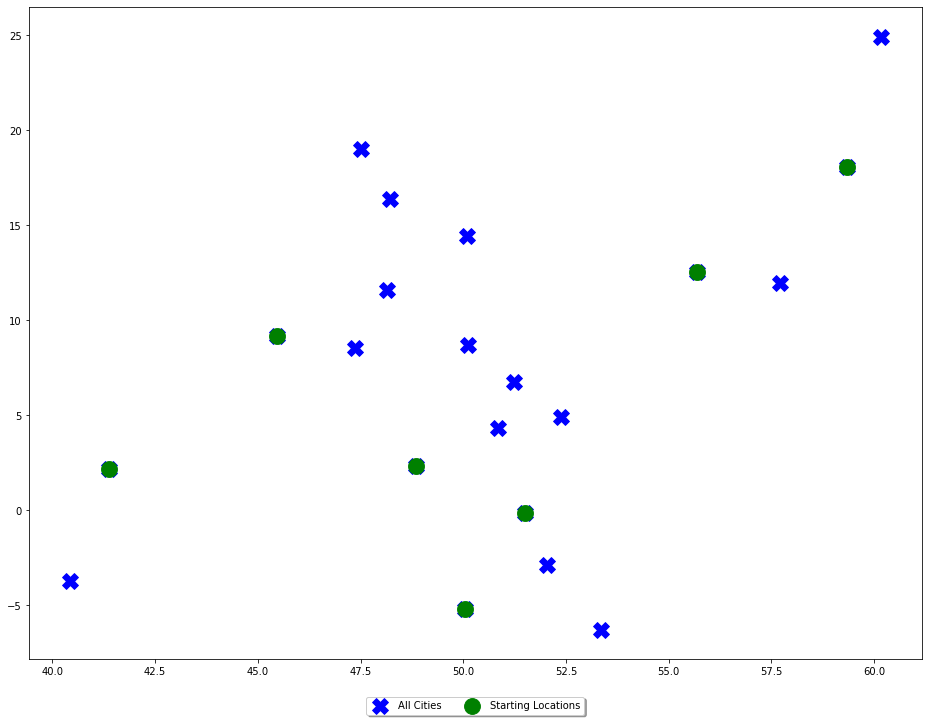

In [11]:
from matplotlib.pyplot import figure
figure(figsize=(16, 12))
plt.scatter(pos_data['Lat'],pos_data['Lon'], s=250, c='blue',marker="X",label='All Cities')
plt.scatter(initial_locs.detach().numpy() [:,0],initial_locs.detach().numpy() [:,1], s=250, c='green',label='Starting Locations')#plt.size()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.show()

## TRAINING THE MODEL 

In [12]:
# setting our training parameters 
lr=0.002
n_epochs = 200
# dataloader to load our data in batches, here we are using a batch size of 1
dl = DataLoader(pos_tensors, batch_size=10, shuffle=False)
# Store loss over time
train_losses = []
val_losses = []
losses_sum=[]
verbose=4
early_stopping=10
best_loss=initial_losses
# for keeping the best locs 
final_locs=cont_locs.clone()
for epoch in range(n_epochs):
   # Run through batches
  for pos_tensor in dl:
    loss2 = (meanC2C_fn(cont_locs,cont_locs+0.00001)+maxC2C_fn( cont_locs,cont_locs+0.00001))*0.1# calculating the intercontroller objective functions
    loss =loss2+ (mean2C_fn(pos_tensors, cont_locs)+maxn2C_fn(pos_tensor, cont_locs))# calculating the intercontroller objective functions
    loss.backward() # Calc grads
    cont_locs.data -= lr * cont_locs.grad.data # Update locs
    cont_locs.grad = None # Reset gradients for next step
  train_losses.append(all_losses(pos_tensor,cont_locs))
  val_loss=all_losses(pos_tensors,cont_locs)
  losses=val_loss.sum()
  if epoch>0 :
    if losses< np.min(losses_sum):
       final_locs=cont_locs.clone()
       best_loss=val_loss
  val_losses.append(val_loss)
  losses_sum.append(losses)
  if epoch % verbose==0:
   print("After {0:.0f} epochs: maxN2c: {1:.2f} meanN2C: {2:.2f} maxICL: {3:.2f} meanICL: {4:.2f} Overall: {5:.2f} ".format(epoch,val_loss[0],val_loss[1],val_loss[2],val_loss[3],losses))
  if epoch > early_stopping:
    if np.min(losses_sum[-early_stopping:])> np.min(losses_sum):
      print ('Training ended by early stopping, best score at epoch {}'.format(epoch))
      break 
print("Best scores at epoch {0} maxN2c: {1:.2f} meanN2C: {2:.2f} maxICL: {3:.2f} meanICL: {4:.2f} Overall: {5:.2f} ".format(epoch,best_loss[0],best_loss[1],best_loss[2],best_loss[3],best_loss.sum()))

After 0 epochs: maxN2c: 483.74 meanN2C: 436.58 maxICL: 14.28 meanICL: 14.57 Overall: 2128.33 
After 4 epochs: maxN2c: 462.85 meanN2C: 420.71 maxICL: 14.39 meanICL: 14.57 Overall: 2055.90 
After 8 epochs: maxN2c: 442.28 meanN2C: 408.25 maxICL: 14.53 meanICL: 14.61 Overall: 1990.98 
After 12 epochs: maxN2c: 422.03 meanN2C: 398.48 maxICL: 14.62 meanICL: 14.64 Overall: 1933.23 
After 16 epochs: maxN2c: 402.07 meanN2C: 390.71 maxICL: 14.63 meanICL: 14.65 Overall: 1881.43 
After 20 epochs: maxN2c: 382.40 meanN2C: 384.45 maxICL: 14.62 meanICL: 14.66 Overall: 1834.64 
After 24 epochs: maxN2c: 363.00 meanN2C: 380.35 maxICL: 14.62 meanICL: 14.68 Overall: 1796.16 
After 28 epochs: maxN2c: 343.85 meanN2C: 378.30 maxICL: 14.61 meanICL: 14.70 Overall: 1765.12 
After 32 epochs: maxN2c: 324.93 meanN2C: 376.52 maxICL: 14.60 meanICL: 14.73 Overall: 1735.56 
After 36 epochs: maxN2c: 306.24 meanN2C: 374.97 maxICL: 14.60 meanICL: 14.76 Overall: 1707.37 
After 40 epochs: maxN2c: 287.74 meanN2C: 373.62 maxIC

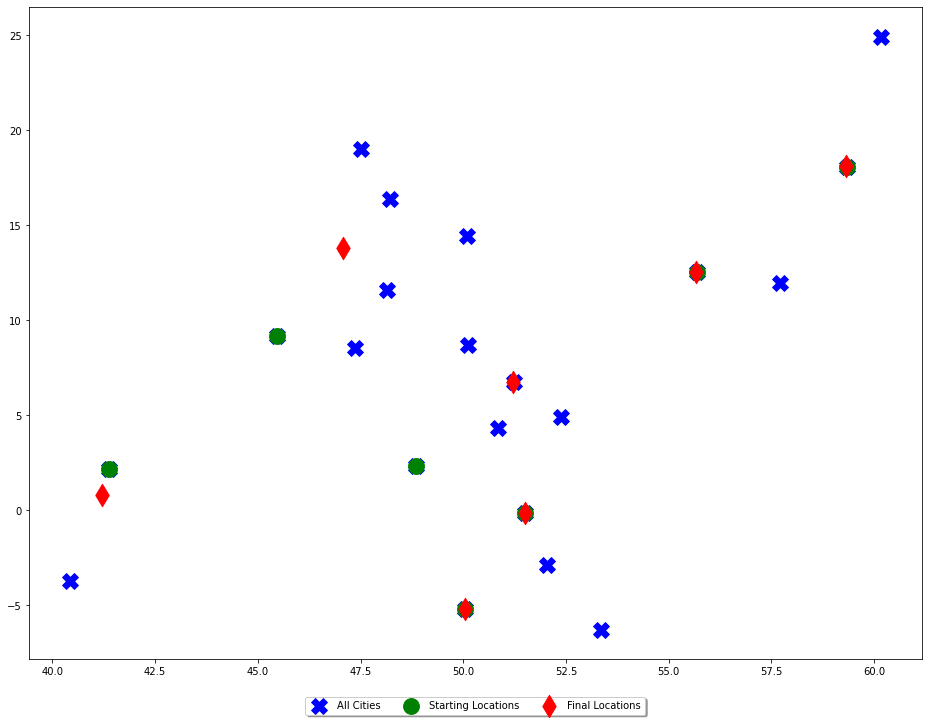

In [13]:
figure(figsize=(16, 12))
plt.scatter(pos_data['Lat'],pos_data['Lon'], s=250, c='blue',marker="X",label='All Cities')
plt.scatter(initial_locs.detach().numpy() [:,0],initial_locs.detach().numpy() [:,1], s=250, c='green',label='Starting Locations')
plt.scatter(final_locs.detach().numpy() [:,0],final_locs.detach().numpy() [:,1], s=250,marker="d", c='red',label='Final Locations')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.show()

In [14]:
val_losses=np.array(val_losses)
train_losses=np.array(train_losses)

In [15]:
def plot_model_performance(val_losses,train_losses):
    """Plot model performance"""
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses[:,0], label = "Training maxN2C")
    plt.plot(val_losses[:,0], label="Validation maxN2C")
    plt.legend()
    plt.title("Training maxN2C vs Validation maxN2C")

    plt.subplot(2,2,2)
    plt.plot(train_losses[:,1], label = "Training meanN2C")
    plt.plot(val_losses[:,1], label="Validation meanN2C")
    plt.legend()
    plt.title("Training meanN2C vs Validation meanN2C")
    plt.show()

    plt.figure(figsize=(15, 8))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses[:,2], label = "Training maxC2C")
    plt.plot(val_losses[:,2], label="Validation maxC2C")
    plt.legend()
    plt.title("Training maxC2C vs Validation maxC2C")

    plt.subplot(2,2,2)
    plt.plot(train_losses[:,3], label = "Training meanC2C")
    plt.plot(val_losses[:,3], label="Validation meanC2C")
    plt.legend()
    plt.title("Training meanC2C vs Validation meanC2C")
    plt.show()

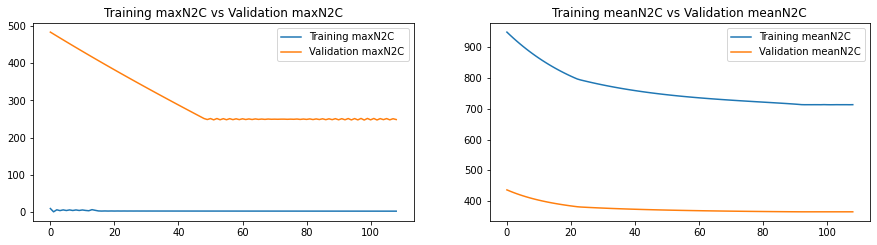

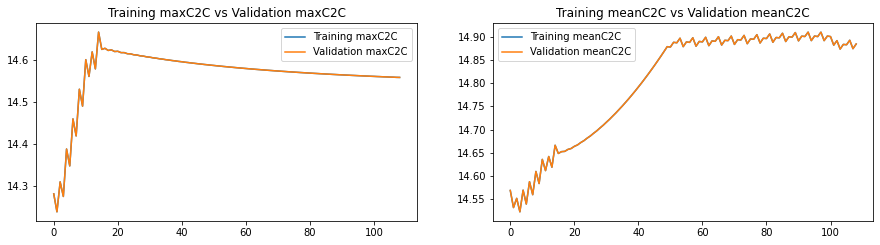

In [16]:
plot_model_performance(val_losses,train_losses)

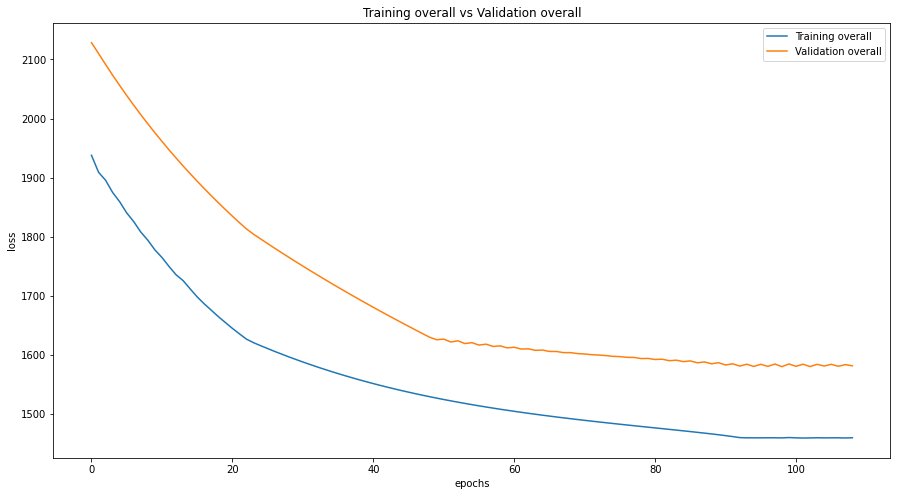

In [17]:
plt.figure(figsize=(15, 8))
plt.plot(train_losses.sum(axis=1), label = "Training overall")
plt.plot(val_losses.sum(axis=1), label="Validation overall")
plt.legend()
plt.title("Training overall vs Validation overall")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [18]:
def loc_to_cities(cont_locs):
  cont_locs=cont_locs.detach()
  min_dists=[]
  for loc in cont_locs:
    dists=haversine(pos_tensors,loc).detach().numpy()
    min_dists.append(np.argmin(dists))
  return min_dists

In [19]:
print(loc_to_cities(final_locs))

[4, 9, 10, 20, 13, 1, 14]
